# Klasifikasi Penyakit Kulit dengan MobileNetV2


**Dataset**: 9 kelas penyakit kulit
**Model**: MobileNetV2 (Transfer Learning)
**Framework**: TensorFlow/Keras


## 1. Import & Setup


In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import json

from sklearn.metrics import classification_report, confusion_matrix

# Konfigurasi
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12  # 10-15 epoch untuk training cepat
DATA_DIR = "dataset"

# Set random seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.15.0
GPU Available: []


## 2. Exploratory Data Understanding (EDU)

struktur dataset, distribusi kelas, dan karakteristik gambar.


In [2]:
# Menampilkan struktur folder dataset
print("=== Struktur Dataset ===\n")
class_names = []
class_counts = []

for class_folder in sorted(os.listdir(DATA_DIR)):
    class_path = os.path.join(DATA_DIR, class_folder)
    if os.path.isdir(class_path):
        num_files = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_names.append(class_folder)
        class_counts.append(num_files)
        print(f"📁 {class_folder}: {num_files} gambar")

print(f"\n✅ Total kelas: {len(class_names)}")
print(f"✅ Total gambar: {sum(class_counts)}")


=== Struktur Dataset ===

📁 Actinic keratosis: 1137 gambar
📁 Atopic Dermatitis: 1136 gambar
📁 Benign keratosis: 1143 gambar
📁 Dermatofibroma: 1142 gambar
📁 Melanocytic nevus: 1129 gambar
📁 Melanoma: 1125 gambar
📁 Squamous cell carcinoma: 1132 gambar
📁 Tinea Ringworm Candidiasis: 810 gambar
📁 Vascular lesion: 1134 gambar

✅ Total kelas: 9
✅ Total gambar: 9888


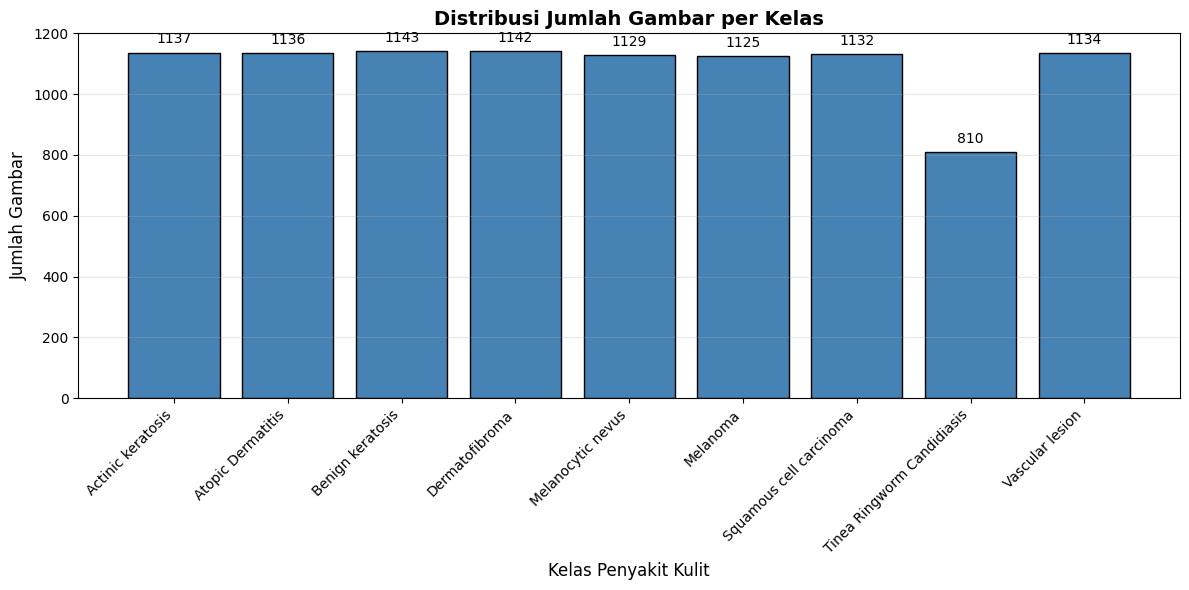


Statistik:
Min: 810 gambar
Max: 1143 gambar
Rata-rata: 1098.7 gambar


In [3]:
# Visualisasi distribusi kelas dengan bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_counts, color='steelblue', edgecolor='black')
plt.title('Distribusi Jumlah Gambar per Kelas', fontsize=14, fontweight='bold')
plt.xlabel('Kelas Penyakit Kulit', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Tambahkan label nilai di atas bar
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nStatistik:")
print(f"Min: {min(class_counts)} gambar")
print(f"Max: {max(class_counts)} gambar")
print(f"Rata-rata: {np.mean(class_counts):.1f} gambar")


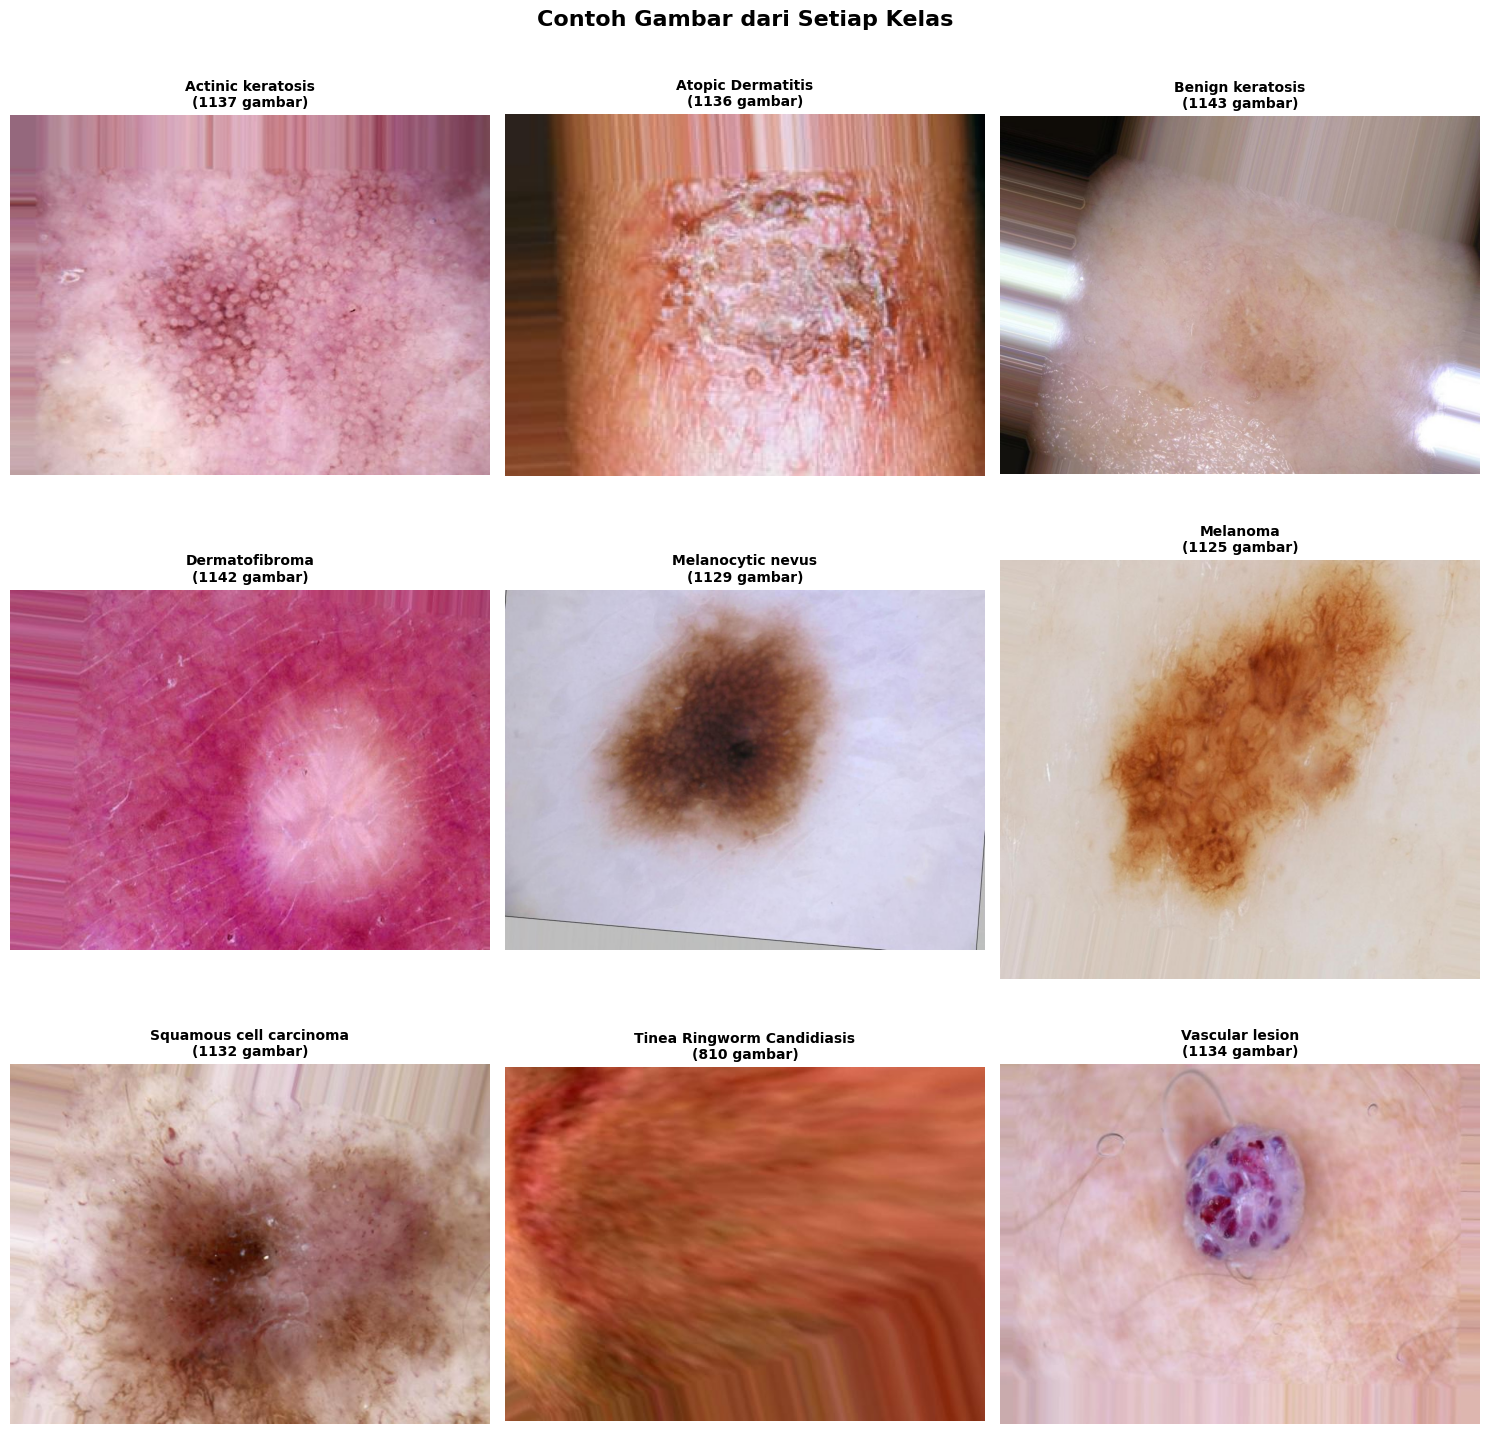

In [4]:
# Menampilkan contoh gambar dari setiap kelas
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{class_name}\n({class_counts[idx]} gambar)", fontsize=10, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Contoh Gambar dari Setiap Kelas', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [5]:
# Memeriksa ukuran gambar asli
image_sizes = []
sample_images = []

for class_name in class_names:  # Baca SEMUA kelas
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        img_path = os.path.join(class_path, image_files[0])  # Ambil 1 sampel dari setiap kelas
        img = Image.open(img_path)
        image_sizes.append(img.size)
        sample_images.append((class_name, img.size))

print("=== Ukuran Gambar Asli (Semua Kelas) ===\n")
for class_name, size in sample_images:
    print(f"{class_name}: {size[0]} x {size[1]} pixels")

print(f"\n✅ Semua gambar akan di-resize menjadi {IMG_SIZE}x{IMG_SIZE} untuk training")


=== Ukuran Gambar Asli (Semua Kelas) ===

Actinic keratosis: 600 x 450 pixels
Atopic Dermatitis: 294 x 222 pixels
Benign keratosis: 1024 x 764 pixels
Dermatofibroma: 600 x 450 pixels
Melanocytic nevus: 1024 x 768 pixels
Melanoma: 919 x 802 pixels
Squamous cell carcinoma: 600 x 450 pixels
Tinea Ringworm Candidiasis: 500 x 368 pixels
Vascular lesion: 600 x 450 pixels

✅ Semua gambar akan di-resize menjadi 224x224 untuk training


## 3. Preprocessing & Normalisasi

In [ ]:
# ImageDataGenerator untuk training dengan augmentasi yang diperkuat
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi pixel values ke [0,1]
    rotation_range=45,  # Rotasi hingga 45 derajat (diperkuat dari 20)
    zoom_range=0.15,  # Zoom in/out hingga 15%
    width_shift_range=0.1,  # Geser horizontal 10%
    height_shift_range=0.1,  # Geser vertikal 10%
    horizontal_flip=True,  # Flip horizontal
    vertical_flip=True,  # Flip vertikal (baru)
    shear_range=0.2,  # Shear transformation hingga 20% (baru)
    fill_mode='reflect'  # Fill mode untuk augmentasi (baru)
)

# ImageDataGenerator untuk validation (tanpa augmentasi)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# ImageDataGenerator untuk test (tanpa augmentasi)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("✅ ImageDataGenerator berhasil dibuat")
print("   Split: Train 70%, Validation 15%, Test 15%")


✅ ImageDataGenerator berhasil dibuat
   Split: Train 70%, Validation 15%, Test 15%


In [ ]:
# Split manual dataset menjadi Train 70%, Validation 15%, Test 15%
from sklearn.model_selection import train_test_split
import shutil

# Buat directory untuk train, validation, dan test set
train_dir = "dataset_train_temp"
val_dir = "dataset_val_temp"
test_dir = "dataset_test_temp"



# Dapatkan daftar kelas dari dataset
class_names = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]

# Split files untuk setiap kelas
print("🔄 Memproses split dataset...")
for class_name in class_names:
    # Buat folder untuk setiap subset
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)
    
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Split: 70% train, 30% untuk val+test
    train_files, val_test_files = train_test_split(image_files, test_size=0.30, random_state=42)
    
    # Split 30% menjadi 15% val dan 15% test (50/50 dari val_test_files)
    val_files, test_files = train_test_split(val_test_files, test_size=0.50, random_state=42)
    
    # Copy files ke direktori masing-masing
    for file in train_files:
        shutil.copy2(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
    
    for file in val_files:
        shutil.copy2(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
    
    for file in test_files:
        shutil.copy2(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

# Buat generator untuk training, validation, dan test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Dataset split selesai:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Number of classes: {train_generator.num_classes}")
print(f"\nClass indices: {train_generator.class_indices}")

# Hitung persentase
total_samples = train_generator.samples + val_generator.samples + test_generator.samples
print(f"\n✅ Final split:")
print(f"   Training: {train_generator.samples} ({train_generator.samples/total_samples*100:.1f}%)")
print(f"   Validation: {val_generator.samples} ({val_generator.samples/total_samples*100:.1f}%)")
print(f"   Test: {test_generator.samples} ({test_generator.samples/total_samples*100:.1f}%)")

# Hitung class weights untuk handling imbalanced data
from sklearn.utils.class_weight import compute_class_weight

# Reset generator untuk mendapatkan classes
train_generator.reset()
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Buat dictionary class_weight untuk model.fit
class_weight_dict = dict(enumerate(class_weights))
print(f"\n✅ Class weights calculated:")
for idx, weight in class_weight_dict.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(idx)]
    print(f"   {class_name}: {weight:.4f}")


🔄 Memproses split dataset...
Found 6918 images belonging to 9 classes.
Found 1482 images belonging to 9 classes.
Found 1488 images belonging to 9 classes.

✅ Dataset split selesai:
   Training samples: 6918
   Validation samples: 1482
   Test samples: 1488
   Number of classes: 9

Class indices: {'Actinic keratosis': 0, 'Atopic Dermatitis': 1, 'Benign keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic nevus': 4, 'Melanoma': 5, 'Squamous cell carcinoma': 6, 'Tinea Ringworm Candidiasis': 7, 'Vascular lesion': 8}

✅ Final split:
   Training: 6918 (70.0%)
   Validation: 1482 (15.0%)
   Test: 1488 (15.0%)

✅ Class weights calculated:
   Actinic keratosis: 0.9669
   Atopic Dermatitis: 0.9669
   Benign keratosis: 0.9608
   Dermatofibroma: 0.9620
   Melanocytic nevus: 0.9730
   Melanoma: 0.9767
   Squamous cell carcinoma: 0.9705
   Tinea Ringworm Candidiasis: 1.3557
   Vascular lesion: 0.9693


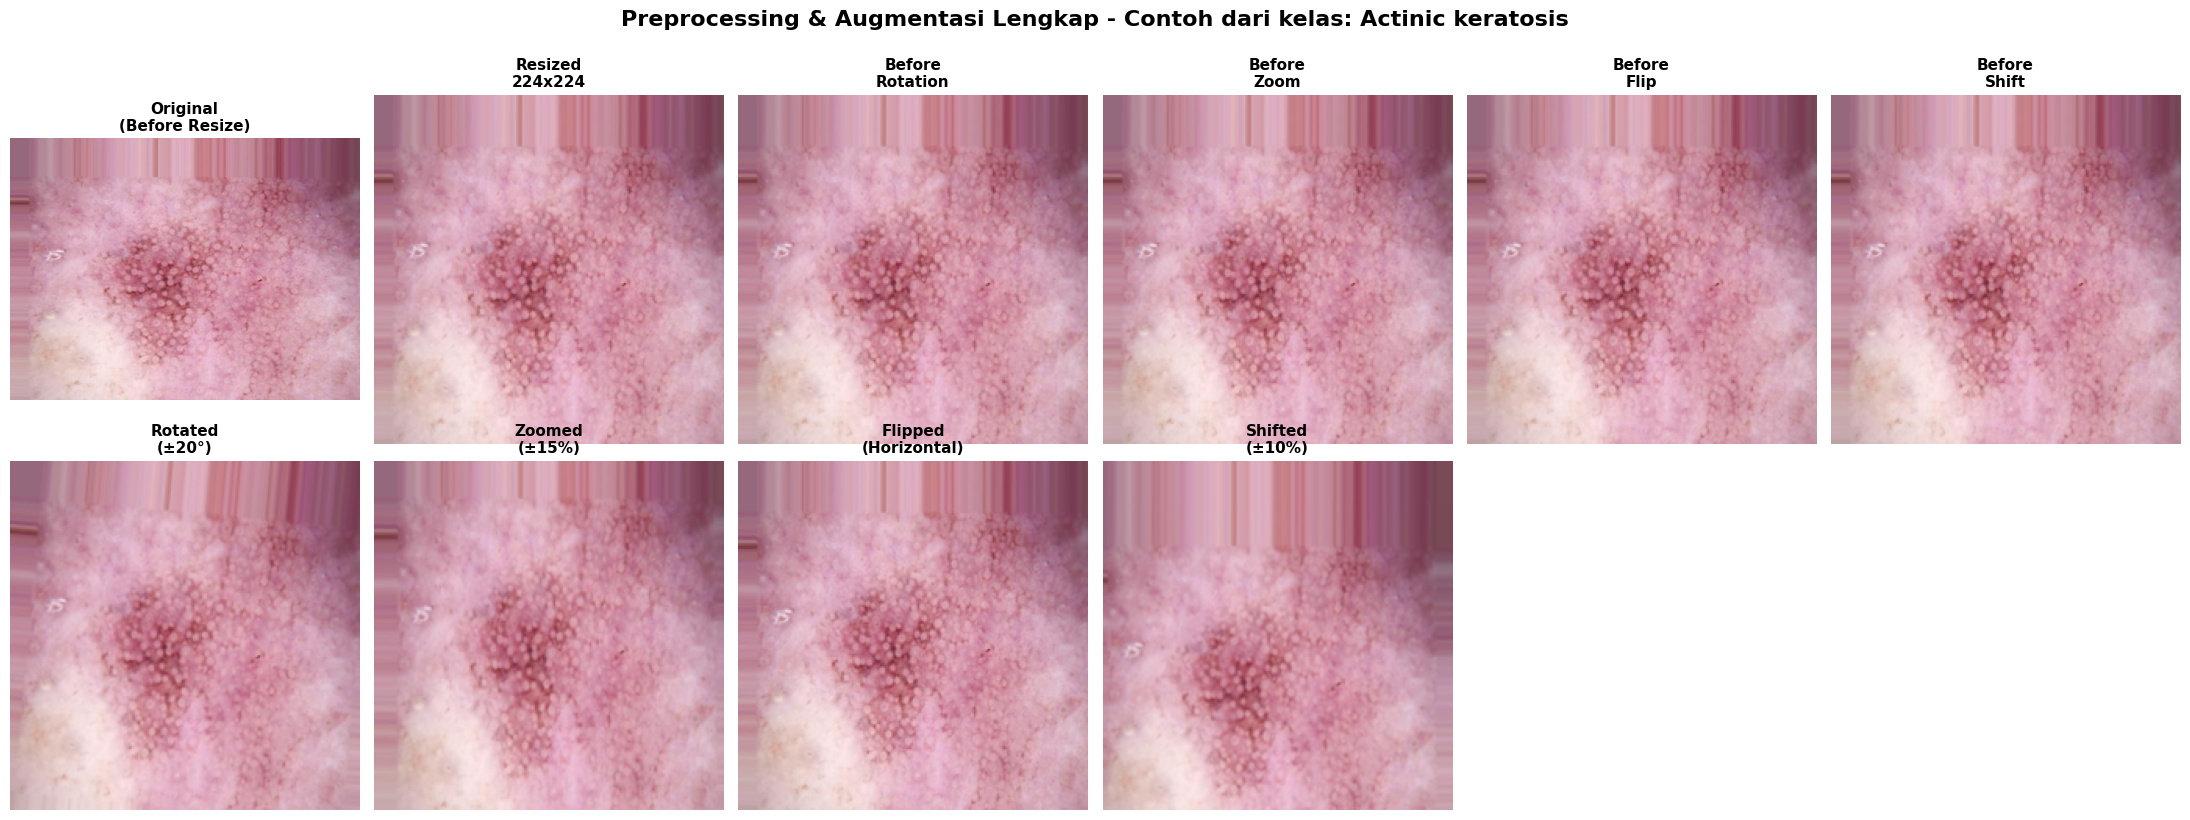


📊 INFORMASI NORMALISASI
Sebelum Normalisasi:
  - Min pixel value: 37
  - Max pixel value: 254
  - Mean pixel value: 172.72

Setelah Normalisasi (÷255):
  - Min pixel value: 0.1451
  - Max pixel value: 0.9961
  - Mean pixel value: 0.6773

✅ Normalisasi dilakukan dengan: rescale=1./255


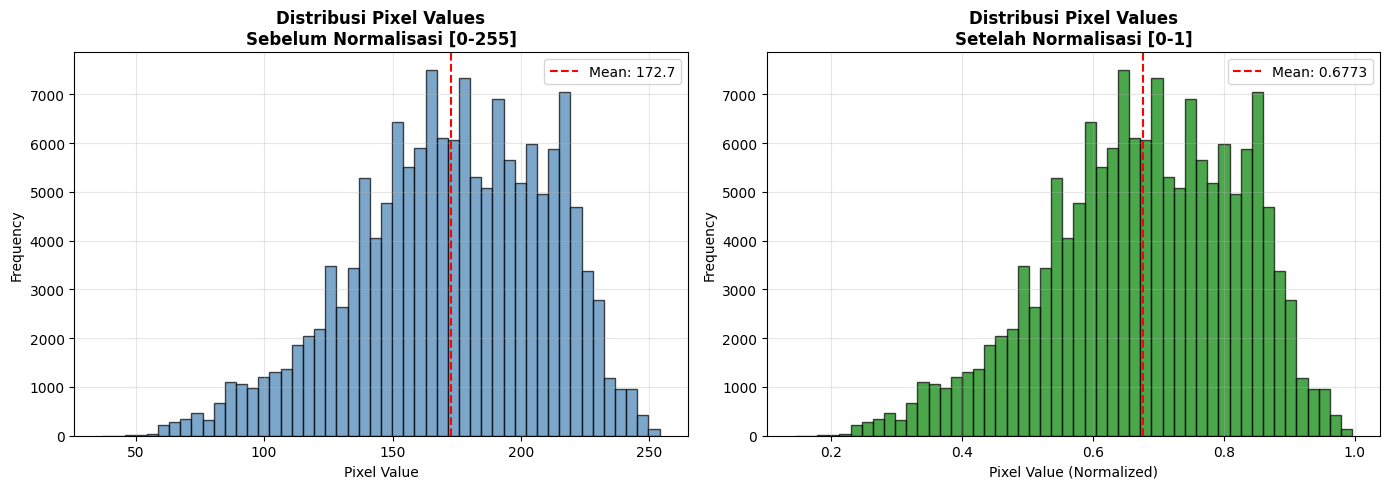


✅ Visualisasi preprocessing & augmentasi selesai.


In [8]:
# ============================================================
# VISUALISASI PREPROCESSING DAN AUGMENTASI LENGKAP (GRID 2×6)
# ============================================================

sample_class = list(train_generator.class_indices.keys())[0]
sample_class_path = os.path.join(DATA_DIR, sample_class)
sample_image_files = [
    f for f in os.listdir(sample_class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

if sample_image_files:
    import math

    # Load gambar asli
    original_img_path = os.path.join(sample_class_path, sample_image_files[0])
    original_img = Image.open(original_img_path)

    # Resize gambar
    resized_img = original_img.resize((IMG_SIZE, IMG_SIZE))

    # Normalisasi
    img_array_original = np.array(resized_img)
    img_array_normalized = img_array_original / 255.0
    img_array = np.expand_dims(img_array_normalized, axis=0)

    # Augmentasi individual
    rotation_datagen = ImageDataGenerator(rotation_range=20)
    zoom_datagen     = ImageDataGenerator(zoom_range=0.15)
    flip_datagen     = ImageDataGenerator(horizontal_flip=True)
    shift_datagen    = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    # Hasil augmentasi
    rotated_img = next(rotation_datagen.flow(img_array, batch_size=1))[0]
    zoomed_img  = next(zoom_datagen.flow(img_array, batch_size=1))[0]
    flipped_img = next(flip_datagen.flow(img_array, batch_size=1))[0]
    shifted_img = next(shift_datagen.flow(img_array, batch_size=1))[0]

    # Daftar gambar BEFORE
    before_imgs = [
        ("Original\n(Before Resize)", original_img),
        ("Resized\n224x224", resized_img),
        ("Before\nRotation", resized_img),
        ("Before\nZoom", resized_img),
        ("Before\nFlip", resized_img),
        ("Before\nShift", resized_img),
    ]

    # Daftar AFTER
    after_imgs = [
        ("Rotated\n(±20°)", rotated_img),
        ("Zoomed\n(±15%)", zoomed_img),
        ("Flipped\n(Horizontal)", flipped_img),
        ("Shifted\n(±10%)", shifted_img),
        ("", None),
        ("", None),
    ]

    # Gabungkan menjadi 2 baris (12 gambar)
    all_titles = [t for t, _ in before_imgs] + [t for t, _ in after_imgs]
    all_images = [i for _, i in before_imgs] + [i for _, i in after_imgs]

    # Buat grid 2 baris × 6 kolom
    fig, axes = plt.subplots(2, 6, figsize=(22, 8))

    idx = 0
    for r in range(2):
        for c in range(6):
            ax = axes[r, c]
            if all_images[idx] is not None:
                ax.imshow(all_images[idx])
            ax.set_title(all_titles[idx], fontsize=11, fontweight='bold')
            ax.axis("off")
            idx += 1

    plt.suptitle(
        f"Preprocessing & Augmentasi Lengkap - Contoh dari kelas: {sample_class}",
        fontsize=16, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()

    # ===========================
    #  Visualisasi Normalisasi
    # ===========================
    print("\n" + "="*60)
    print("📊 INFORMASI NORMALISASI")
    print("="*60)
    print(f"Sebelum Normalisasi:")
    print(f"  - Min pixel value: {img_array_original.min()}")
    print(f"  - Max pixel value: {img_array_original.max()}")
    print(f"  - Mean pixel value: {img_array_original.mean():.2f}")
    print(f"\nSetelah Normalisasi (÷255):")
    print(f"  - Min pixel value: {img_array_normalized.min():.4f}")
    print(f"  - Max pixel value: {img_array_normalized.max():.4f}")
    print(f"  - Mean pixel value: {img_array_normalized.mean():.4f}")
    print(f"\n✅ Normalisasi dilakukan dengan: rescale=1./255")
    print("="*60)

    # Histogram
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram sebelum normalisasi
    axes[0].hist(img_array_original.flatten(), bins=50,
                 color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_title("Distribusi Pixel Values\nSebelum Normalisasi [0-255]",
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Pixel Value")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(img_array_original.mean(),
                    color='red', linestyle='--',
                    label=f"Mean: {img_array_original.mean():.1f}")
    axes[0].legend()

    # Histogram setelah normalisasi
    axes[1].hist(img_array_normalized.flatten(), bins=50,
                 color='green', edgecolor='black', alpha=0.7)
    axes[1].set_title("Distribusi Pixel Values\nSetelah Normalisasi [0-1]",
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Pixel Value (Normalized)")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(img_array_normalized.mean(),
                    color='red', linestyle='--',
                    label=f"Mean: {img_array_normalized.mean():.4f}")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    print("\n✅ Visualisasi preprocessing & augmentasi selesai.")


## 4. Build & Train Model (MobileNetV2)

Membangun model menggunakan transfer learning dengan MobileNetV2 sebagai base model.


In [9]:
# Load MobileNetV2 sebagai base model (pre-trained on ImageNet)
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model (tidak di-train)
base_model.trainable = False

print("✅ Base model MobileNetV2 loaded")
print(f"✅ Base model trainable: {base_model.trainable}")




✅ Base model MobileNetV2 loaded
✅ Base model trainable: False


In [ ]:
# Membangun model lengkap dengan arsitektur yang dioptimasi
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),  # Dropout 0.3 untuk regulasi yang lebih kuat
    layers.Dense(train_generator.num_classes, activation='softmax')  # Langsung ke output layer (9 classes)
])

# Compile model untuk Stage 1 (Transfer Learning)
# Learning rate akan diubah di Stage 2
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan summary model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 2269513 (8.66 MB)
Trainable params: 11529 (45.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Callbacks untuk Stage 1 (Transfer Learning)
callbacks_stage1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'skin_disease_mobilenetv2_stage1.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Callbacks untuk Stage 2 (Fine-Tuning)
callbacks_stage2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,  # Lebih sabar untuk fine-tuning
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'skin_disease_mobilenetv2.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✅ Callbacks configured:")
print("   Stage 1 - EarlyStopping: patience=3, ModelCheckpoint: stage1 model")
print("   Stage 2 - EarlyStopping: patience=7, ModelCheckpoint: final model")


✅ Callbacks configured:
   Stage 1 - EarlyStopping: patience=3, ModelCheckpoint: stage1 model
   Stage 2 - EarlyStopping: patience=7, ModelCheckpoint: final model


In [ ]:
# ============================================================
# TWO-STAGE TRAINING STRATEGY
# ============================================================

print("="*60)
print("🚀 MEMULAI TWO-STAGE TRAINING STRATEGY")
print("="*60)
print("⚠️  Catatan: Warning yang muncul adalah normal dan tidak mempengaruhi kualitas model.\n")

# ============================================================
# STAGE 1: TRANSFER LEARNING
# ============================================================
print("\n" + "="*60)
print("📌 STAGE 1: TRANSFER LEARNING")
print("="*60)
print("   - Base model: FROZEN (semua layer MobileNetV2)")
print("   - Optimizer: Adam dengan learning_rate=1e-4")
print("   - Epochs: 10 (dengan EarlyStopping patience=3)")
print("   - Class weights: Diterapkan untuk handling imbalanced data")
print("="*60 + "\n")

# Pastikan base_model frozen
base_model.trainable = False
print(f"✅ Base model trainable: {base_model.trainable}")

# Recompile untuk memastikan base_model frozen
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training Stage 1
history_stage1 = model.fit(
    train_generator,
    epochs=10,  # 10 epochs untuk Stage 1
    validation_data=val_generator,
    callbacks=callbacks_stage1,
    class_weight=class_weight_dict,  # Terapkan class weights
    verbose=1
)

print("\n✅ Stage 1 (Transfer Learning) selesai!")

# ============================================================
# STAGE 2: FINE-TUNING
# ============================================================
print("\n" + "="*60)
print("📌 STAGE 2: FINE-TUNING")
print("="*60)
print("   - Base model: UNFROZEN (30 layer terakhir)")
print("   - Optimizer: Adam dengan learning_rate=1e-5 (sangat kecil)")
print("   - Epochs: 20 (dengan EarlyStopping patience=7)")
print("   - Class weights: Diterapkan untuk handling imbalanced data")
print("="*60 + "\n")

# Unfreeze 30 layer terakhir dari base_model
base_model.trainable = True
# Set semua layer menjadi non-trainable terlebih dahulu
for layer in base_model.layers[:-30]:
    layer.trainable = False
# Hanya 30 layer terakhir yang trainable
for layer in base_model.layers[-30:]:
    layer.trainable = True

print(f"✅ Base model trainable: {base_model.trainable}")
print(f"✅ Jumlah layer yang di-unfreeze: 30 layer terakhir")

# Recompile dengan learning rate yang lebih kecil
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate sangat kecil untuk fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training Stage 2
history_stage2 = model.fit(
    train_generator,
    epochs=20,  # 20 epochs untuk Stage 2
    validation_data=val_generator,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict,  # Terapkan class weights
    verbose=1
)

print("\n✅ Stage 2 (Fine-Tuning) selesai!")
print("\n" + "="*60)
print("✅ TWO-STAGE TRAINING SELESAI!")
print("="*60)

# Gabungkan history dari kedua stage
# Buat objek history yang kompatibel dengan visualisasi
class CombinedHistory:
    def __init__(self, history1, history2):
        self.history = {
            'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
            'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
            'loss': history1.history['loss'] + history2.history['loss'],
            'val_loss': history1.history['val_loss'] + history2.history['val_loss']
        }

history = CombinedHistory(history_stage1, history_stage2)


🚀 MEMULAI TWO-STAGE TRAINING STRATEGY
⚠️  Catatan: Warning yang muncul adalah normal dan tidak mempengaruhi kualitas model.


📌 STAGE 1: TRANSFER LEARNING
   - Base model: FROZEN (semua layer MobileNetV2)
   - Optimizer: Adam dengan learning_rate=1e-4
   - Epochs: 10 (dengan EarlyStopping patience=3)
   - Class weights: Diterapkan untuk handling imbalanced data

✅ Base model trainable: False
Epoch 1/10


217/217 [==============================] - ETA: 0s - loss: 2.2708 - accuracy: 0.2040
Epoch 1: val_accuracy improved from -inf to 0.41026, saving model to skin_disease_mobilenetv2_stage1.h5


C:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 312s 1s/step - loss: 2.2708 - accuracy: 0.2040 - val_loss: 1.6604 - val_accuracy: 0.4103
Epoch 2/10
217/217 [==============================] - ETA: 0s - loss: 1.6303 - accuracy: 0.4164
Epoch 2: val_accuracy improved from 0.41026 to 0.56680, saving model to skin_disease_mobilenetv2_stage1.h5
217/217 [==============================] - 186s 858ms/step - loss: 1.6303 - accuracy: 0.4164 - val_loss: 1.2681 - val_accuracy: 0.5668
Epoch 3/10
217/217 [==============================] - ETA: 0s - loss: 1.3624 - accuracy: 0.5176
Epoch 3: val_accuracy improved from 0.56680 to 0.64035, saving model to skin_disease_mobilenetv2_stage1.h5
217/217 [==============================] - 189s 872ms/step - loss: 1.3624 - accuracy: 0.5176 - val_loss: 1.0797 - val_accuracy: 0.6404
Epoch 4/10
217/217 [==============================] - ETA: 0s - loss: 1.1800 - accuracy: 0.5836
Epoch 4: val_accuracy improved from 0.64035 to 0.67544, saving model to skin_disease_mobilenetv2

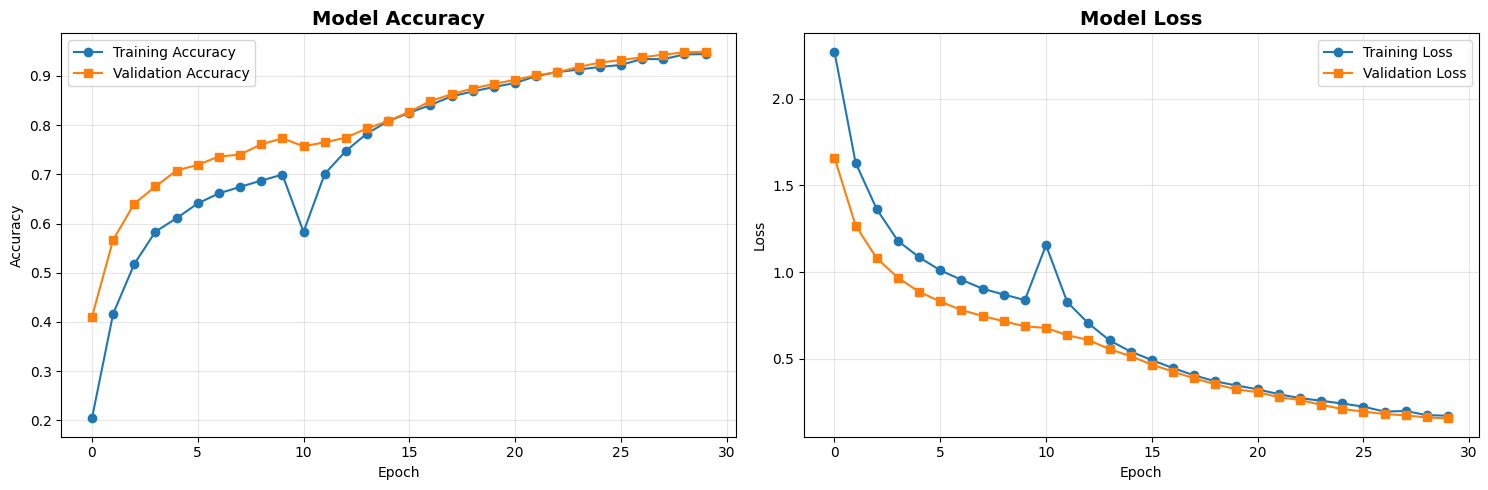


📊 Best Validation Accuracy: 0.9494
📊 Best Validation Loss: 0.1568


In [13]:
# Visualisasi training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best values
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
print(f"\n📊 Best Validation Accuracy: {best_val_acc:.4f}")
print(f"📊 Best Validation Loss: {best_val_loss:.4f}")


In [14]:
# Simpan model final
model.save("skin_disease_mobilenetv2.h5")
print("✅ Model disimpan sebagai 'skin_disease_mobilenetv2.h5'")


✅ Model disimpan sebagai 'skin_disease_mobilenetv2.h5'


## 5. Evaluasi Model

Evaluasi performa model menggunakan test set dengan confusion matrix dan classification report.


In [15]:
# Prediksi pada test set
print("🔄 Melakukan prediksi pada test set...")

# Reset generator untuk memastikan urutan konsisten
test_generator.reset()

# Prediksi
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"✅ Prediksi selesai: {len(y_pred)} samples")


🔄 Melakukan prediksi pada test set...
47/47 [==============================] - 49s 1s/step
✅ Prediksi selesai: 1488 samples


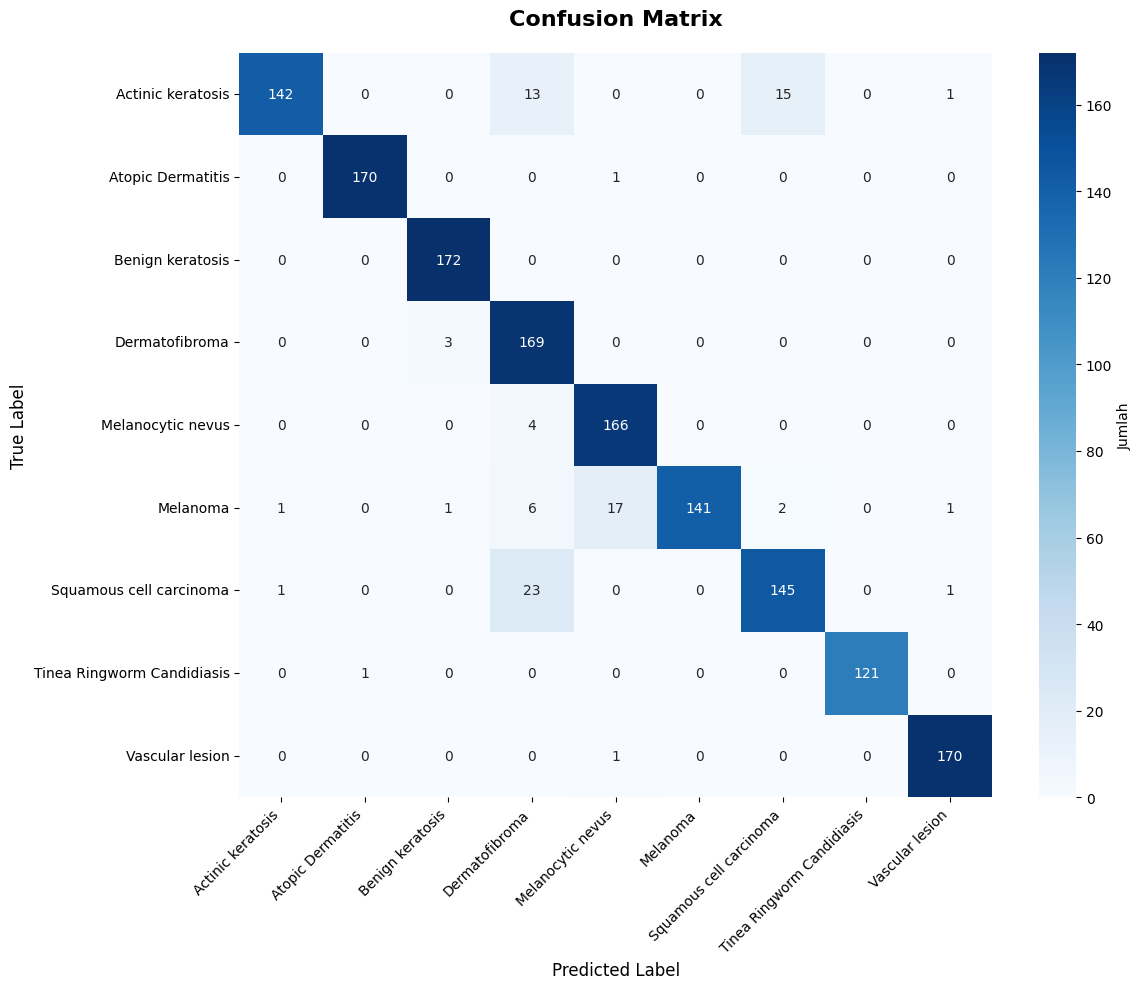

In [16]:
# Confusion Matrix
class_labels = list(train_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Jumlah'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
# Simpan class indices ke file JSON
with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f, indent=2)

print("✅ Class indices disimpan ke 'class_indices.json'")
print("\n📋 Mapping Kelas ke Index:")
for class_name, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1]):
    print(f"   {idx}: {class_name}")


✅ Class indices disimpan ke 'class_indices.json'

📋 Mapping Kelas ke Index:
   0: Actinic keratosis
   1: Atopic Dermatitis
   2: Benign keratosis
   3: Dermatofibroma
   4: Melanocytic nevus
   5: Melanoma
   6: Squamous cell carcinoma
   7: Tinea Ringworm Candidiasis
   8: Vascular lesion


## 6. Cleanup

Membersihkan direktori temporary yang dibuat untuk split dataset.


In [18]:
# Cleanup: Hapus direktori temporary setelah training selesai
import shutil

temp_dirs = ["dataset_train_temp", "dataset_val_temp", "dataset_test_temp"]
print("🧹 Membersihkan direktori temporary...")

for temp_dir in temp_dirs:
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
        print(f"   ✅ Dihapus: {temp_dir}")

print("✅ Cleanup selesai!")


🧹 Membersihkan direktori temporary...
   ✅ Dihapus: dataset_train_temp
   ✅ Dihapus: dataset_val_temp
   ✅ Dihapus: dataset_test_temp
✅ Cleanup selesai!


In [19]:
# Classification Report
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Overall Accuracy
overall_accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\n{'='*60}")
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"{'='*60}")


CLASSIFICATION REPORT
                            precision    recall  f1-score   support

         Actinic keratosis       0.99      0.83      0.90       171
         Atopic Dermatitis       0.99      0.99      0.99       171
          Benign keratosis       0.98      1.00      0.99       172
            Dermatofibroma       0.79      0.98      0.87       172
         Melanocytic nevus       0.90      0.98      0.94       170
                  Melanoma       1.00      0.83      0.91       169
   Squamous cell carcinoma       0.90      0.85      0.87       170
Tinea Ringworm Candidiasis       1.00      0.99      1.00       122
           Vascular lesion       0.98      0.99      0.99       171

                  accuracy                           0.94      1488
                 macro avg       0.95      0.94      0.94      1488
              weighted avg       0.94      0.94      0.94      1488


Overall Accuracy: 0.9382 (93.82%)


## 6. Simpan Class Indices

Menyimpan mapping kelas ke index untuk digunakan saat inference atau deployment.


In [20]:
   pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
